In [188]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
import numpy as np
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import glob
import plotly.express as px

# Read in all the data

Functions to get the common names of the proteins: 

In [189]:
# function to match gene symbols to monomer ids
def get_gene_symbols_for_monomer_ids():
	"""
	Extracts the gene symbols for each monomer id in the model.
	Returns: a dictionary mapping monomer ids to gene symbols.
	Code adapted from convert_to_flat.py.
	"""
	RNAS_FILE = os.path.join(ROOT_PATH, 'reconstruction', 'ecoli',
								 'flat', 'rnas.tsv')
	with (io.open(RNAS_FILE, 'rb') as f):
		reader = tsv.reader(f, delimiter='\t')
		headers = next(reader)
		while headers[0].startswith('#'):
			headers = next(reader)

		# extract relevant information
		gene_symbol_index = headers.index('common_name')
		protein_id_index = headers.index('monomer_ids')
		monomer_ids_to_gene_symbols = {}
		for line in reader:
			gene_symbol = line[gene_symbol_index]
			protein_id = list(
				line[protein_id_index][2:-2].split('", "'))[0]
			monomer_ids_to_gene_symbols[protein_id] = gene_symbol

	return monomer_ids_to_gene_symbols

def get_common_name(protein_id):
    """
    Get the common name of a protein given its monomer id.
    Args:
        protein_id: the name of the monomer

    Returns:
        common_name: The common name of the protein.

    """
    if '[' in protein_id:
        protein_id = protein_id[:-3]  # subtract the compartment
        
    if protein_id == 'NG-GFP-MONOMER':
        print('NEW GENE PRESENT')
    else:
        common_name = get_gene_symbols_for_monomer_ids()[protein_id]
    return common_name

# Generate the data table with all the infomration needed

Note that here is where the current_sequence and CLNE_sequence are defined, as well as all the files read in to make the tables!

In [190]:
# read in the CLNE1 half life data: 
CLNE1_HLs = "out/CLNE1/kb_plot_out/protein_half_lives.tsv"
CLNE1_HLs = pd.read_csv(CLNE1_HLs, sep='\t')
CLNE1_HLs = CLNE1_HLs.rename(columns={"half_life_(min)": "original_half_life"})
CLNE1_HLs = CLNE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# read in the CLClim3NE1 half life data:
CLClim3NE1_HLs = "out/CLClim3NE1/kb_plot_out/protein_half_lives.tsv"
CLClim3NE1_HLs = pd.read_csv(CLClim3NE1_HLs, sep='\t')
CLClim3NE1_HLs = CLClim3NE1_HLs.rename(columns={"half_life_(min)": "new_half_life"})
CLClim3NE1_HLs = CLClim3NE1_HLs.drop(columns={"degradation_rate(1/s)", "degradation_rate_source"})

# merge the two together: 
combined_df = pd.merge(CLClim3NE1_HLs, CLNE1_HLs, on='monomer_id', how='inner')

# add the common names to the dataframe:
combined_df['common_name'] = None
for index, row in combined_df.iterrows():
    common_name = get_common_name(row['monomer_id'])
    combined_df.at[index, 'common_name'] = common_name

# add the counts data: 
current_sequence = "CLClim3NE1"
CLNE_sequence = "CLNE_11192024"
CLNE_new_name = "Log10 " +CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"

# read in the unfiltered data and remove the last three characters from each entry in the Monomer ID column: 
CLClimNE_log_data = pd.read_csv(
    'out/CLClim3NE1/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLClimNE_log_data['Monomer ID'] = CLClimNE_log_data['Monomer ID'].str[:-3]

# do the same for the 2020 model:
CLNE_log_data = pd.read_csv('/Users/miagrahn/wcEcoli/out/CLNE_11192024/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# merge the two dataframes:
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})
CLClimNE_log_data = CLClimNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
CLClimNE_log_data = CLClimNE_log_data.set_index("Monomer ID")
# CLNE_log_data = CLNE_log_data.reset_index()
# CLClimNE_log_data = CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_log_data.join(CLClimNE_log_data, on="Monomer ID", how="inner")
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.reset_index()
CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.rename(columns={"Monomer ID": "monomer_id"})
#CLNE_CLClimNE_log_data = CLNE_CLClimNE_log_data.set_index("monomer_id")


# merge into combined_df:
combined_df = pd.merge(combined_df, CLNE_CLClimNE_log_data, on='monomer_id', how='inner')

# add new half life (HL) columns: 
# find the differences between the orginal half life and the new half life:
combined_df['HL_difference'] = combined_df['new_half_life'] - combined_df['original_half_life']
# make a new column that is the fold change in half life:
combined_df['HL_fold_change'] = combined_df['new_half_life'] / combined_df['original_half_life']
# calcuate the ln 2 fold change:
combined_df['HL_ln2_fold_change'] = np.log2(combined_df['HL_fold_change'])

# add new protein count (PC) columns:
# find the differences between the orginal protein counts and the new protein counts:
combined_df['PC_difference'] = 10**(combined_df[CLClimNE_new_name]) - 10**(combined_df[CLNE_new_name])
# make a new column that is the fold change in protein counts:
combined_df['PC_fold_change'] = 10**(combined_df[CLClimNE_new_name]) / 10**(combined_df[CLNE_new_name])
# calcuate the ln 2 fold change:
combined_df['PC_ln2_fold_change'] = np.log2(combined_df['PC_fold_change'])

combined_df['counts_new_+10'] = np.log10(10**(combined_df[CLClimNE_new_name]) + 10)
combined_df['counts_old_+10'] = np.log10(10**(combined_df[CLNE_new_name]) + 10)
combined_df['ln2_counts_10'] = np.log2(combined_df['counts_new_+10'] / combined_df['counts_old_+10'])



combined_df

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,HL_difference,HL_fold_change,HL_ln2_fold_change,PC_difference,PC_fold_change,PC_ln2_fold_change,counts_new_+10,counts_old_+10,ln2_counts_10
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.248895,2.239675,-98.292107,0.836180,-0.258115,-3.725917,0.978994,-0.030628,2.263991,2.272714,-0.005548
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.829031,1.747600,166.256894,1.277095,0.352866,-11.533466,0.829027,-0.270510,1.819045,1.889064,-0.054491
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.000000,600.0,panE,2.155309,2.321794,0.000000,1.000000,0.000000,66.803382,1.467186,0.553052,2.342016,2.184666,0.100339
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.603593,3.482980,-323.075668,0.461541,-1.115471,-973.400628,0.757507,-0.400668,3.484405,3.604673,-0.048956
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.619919,2.695617,-106.602950,0.822328,-0.282213,79.362614,1.190413,0.251462,2.704283,2.630216,0.040065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.591232,1.180822,54.149344,1.090249,0.124658,-23.850743,0.388678,-1.363352,1.400785,1.690329,-0.271069
4306,YTFT-MONOMER,600.000000,600.0,ytfT,1.569764,1.138950,0.000000,1.000000,0.000000,-23.362790,0.370840,-1.431131,1.376039,1.673328,-0.282199
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.792515,2.872238,38.129701,1.063550,0.088887,124.963953,1.201497,0.264833,2.878028,2.799462,0.039931
4308,ZNUB-MONOMER,600.000000,600.0,znuB,1.856827,1.829640,0.000000,1.000000,0.000000,-4.363893,0.939320,-0.090312,1.889595,1.913370,-0.018039


# Generate the ln2 fold change in HL plot

greater than 2: 7
between 2 and 0: 1203
exactly 0: 1635
between 0 and -3: 1395
less than -3: 70


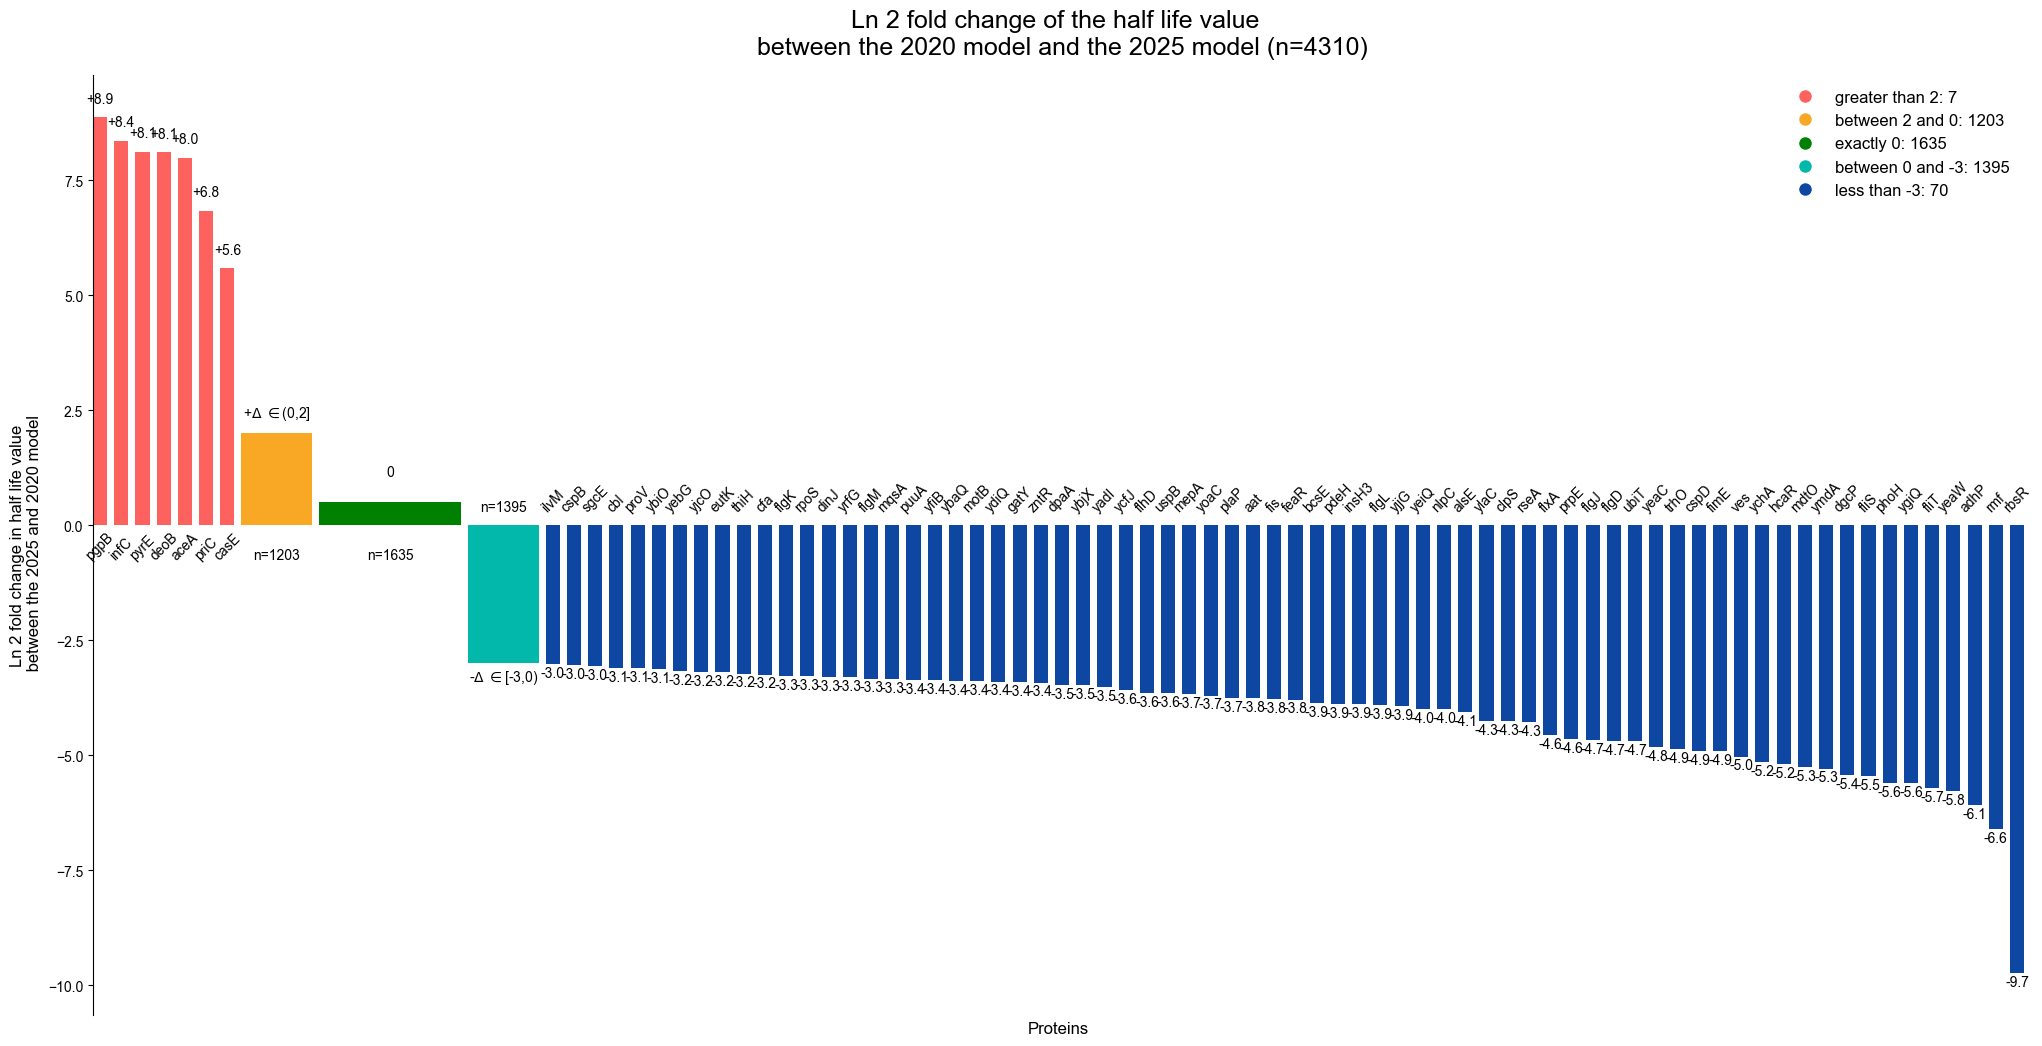

In [191]:
# define the data to use: 
df = combined_df.copy()

# define column to plot: 
column = 'HL_ln2_fold_change'

# define bounds for changes
upper = 2
middle = 0
lower = -3

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/ln2_fold_change_in_HL_values_with_all_proteins_[{lower},{middle},{upper}].png"

# define the title of the plot:
title0 = f'Ln 2 fold change of the half life value \n between the 2020 model and the 2025 model (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Ln 2 fold change in half life value\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Generate the ln2 fold change protein count bar plot

greater than 4: 26
between 4 and 0: 1565
exactly 0: 147
between 0 and -4: 2515
less than -4: 57


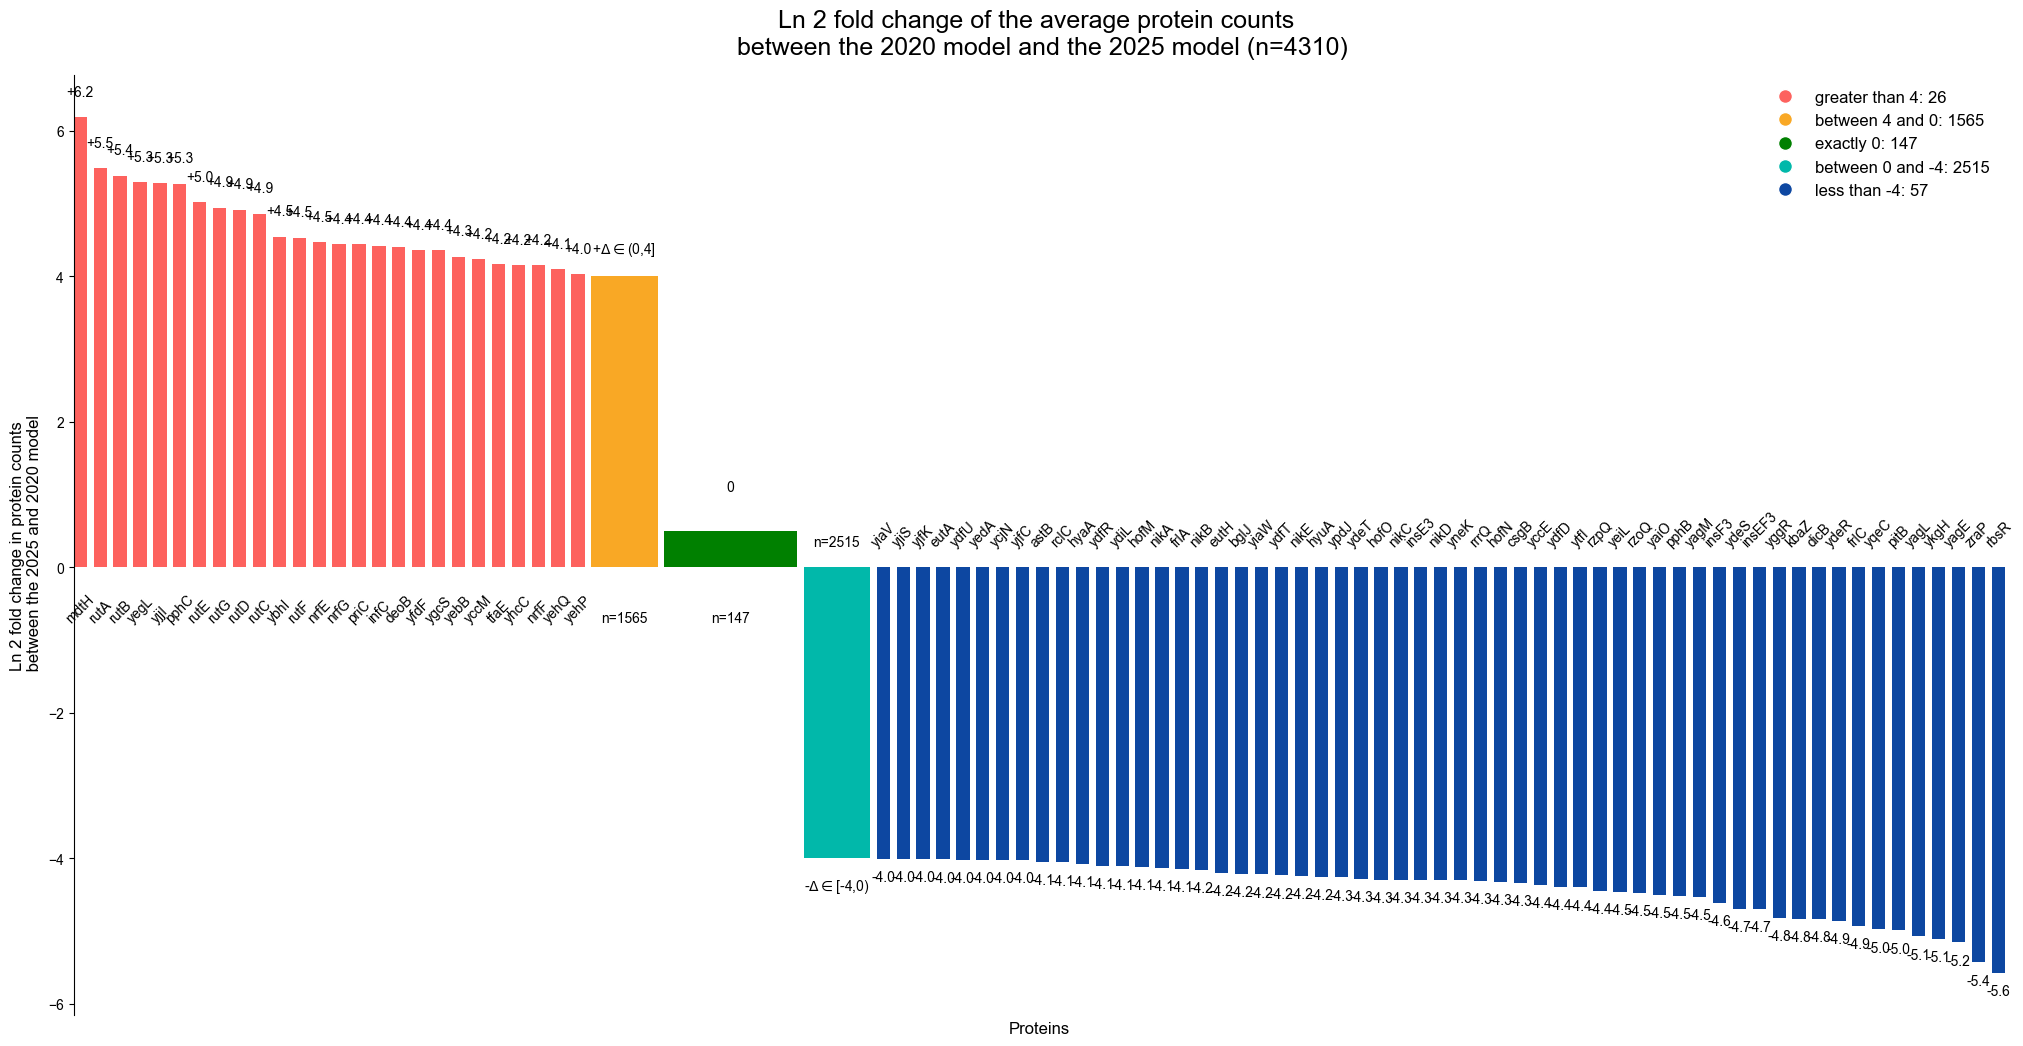

In [192]:
# define the data to use: 
df = combined_df.copy()

# define column to plot: 
column = 'PC_ln2_fold_change'

# define bounds for changes
upper = 4
middle = 0
lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/ln2_fold_change_in_protein_count_values_with_all_proteins_[{lower},{middle},{upper}].png"

# define the title of the plot:
title0 = f'Ln 2 fold change of the average protein counts \n between the 2020 model and the 2025 model (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Ln 2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot the ln 2 fold change of the protein counts using only the proteins that had a change in half life from their original value

First prep the data: 

In [193]:
combined_df_of_proteins_with_new_HLs = combined_df.copy()

# remove the proteins that have a different half life value between new_half_life and original_half_life:
combined_df_of_proteins_with_new_HLs = combined_df_of_proteins_with_new_HLs[combined_df_of_proteins_with_new_HLs['HL_difference'] != 0] # should add up to 2675, as I believe that is how many were reassigned to Gupta et al. 2024 data! 

combined_df_of_proteins_with_new_HLs

,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,HL_difference,HL_fold_change,HL_ln2_fold_change,PC_difference,PC_fold_change,PC_ln2_fold_change,counts_new_+10,counts_old_+10,ln2_counts_10
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,501.707893,600.0,plsC,2.248895,2.239675,-98.292107,0.836180,-0.258115,-3.725917,0.978994,-0.030628,2.263991,2.272714,-0.005548
1,1-PFK-MONOMER,766.256894,600.0,fruK,1.829031,1.747600,166.256894,1.277095,0.352866,-11.533466,0.829027,-0.270510,1.819045,1.889064,-0.054491
3,2-ISOPROPYLMALATESYN-MONOMER,276.924332,600.0,leuA,3.603593,3.482980,-323.075668,0.461541,-1.115471,-973.400628,0.757507,-0.400668,3.484405,3.604673,-0.048956
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,493.397050,600.0,ubiE,2.619919,2.695617,-106.602950,0.822328,-0.282213,79.362614,1.190413,0.251462,2.704283,2.630216,0.040065
5,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,796.038829,600.0,ubiB,1.791572,1.887357,196.038829,1.326731,0.407876,15.270692,1.246767,0.318192,1.940286,1.856627,0.063586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4302,YRBF-MONOMER,823.833163,600.0,mlaF,2.469536,2.572575,223.833163,1.373055,0.457390,78.938638,1.267765,0.342287,2.584042,2.484023,0.056951
4304,YTFQ-MONOMER,790.418789,600.0,ytfQ,1.641263,1.298067,190.418789,1.317365,0.397655,-23.914713,0.453737,-1.140072,1.475148,1.730611,-0.230421
4305,YTFR-MONOMER,654.149344,600.0,ytfR,1.591232,1.180822,54.149344,1.090249,0.124658,-23.850743,0.388678,-1.363352,1.400785,1.690329,-0.271069
4307,ZNUA-MONOMER,638.129701,600.0,znuA,2.792515,2.872238,38.129701,1.063550,0.088887,124.963953,1.201497,0.264833,2.878028,2.799462,0.039931


Generate the ln2 fold change protein count bar plot:

greater than 3: 18
between 3 and 0: 954
exactly 0: 3
between 0 and -3: 1658
less than -3: 42


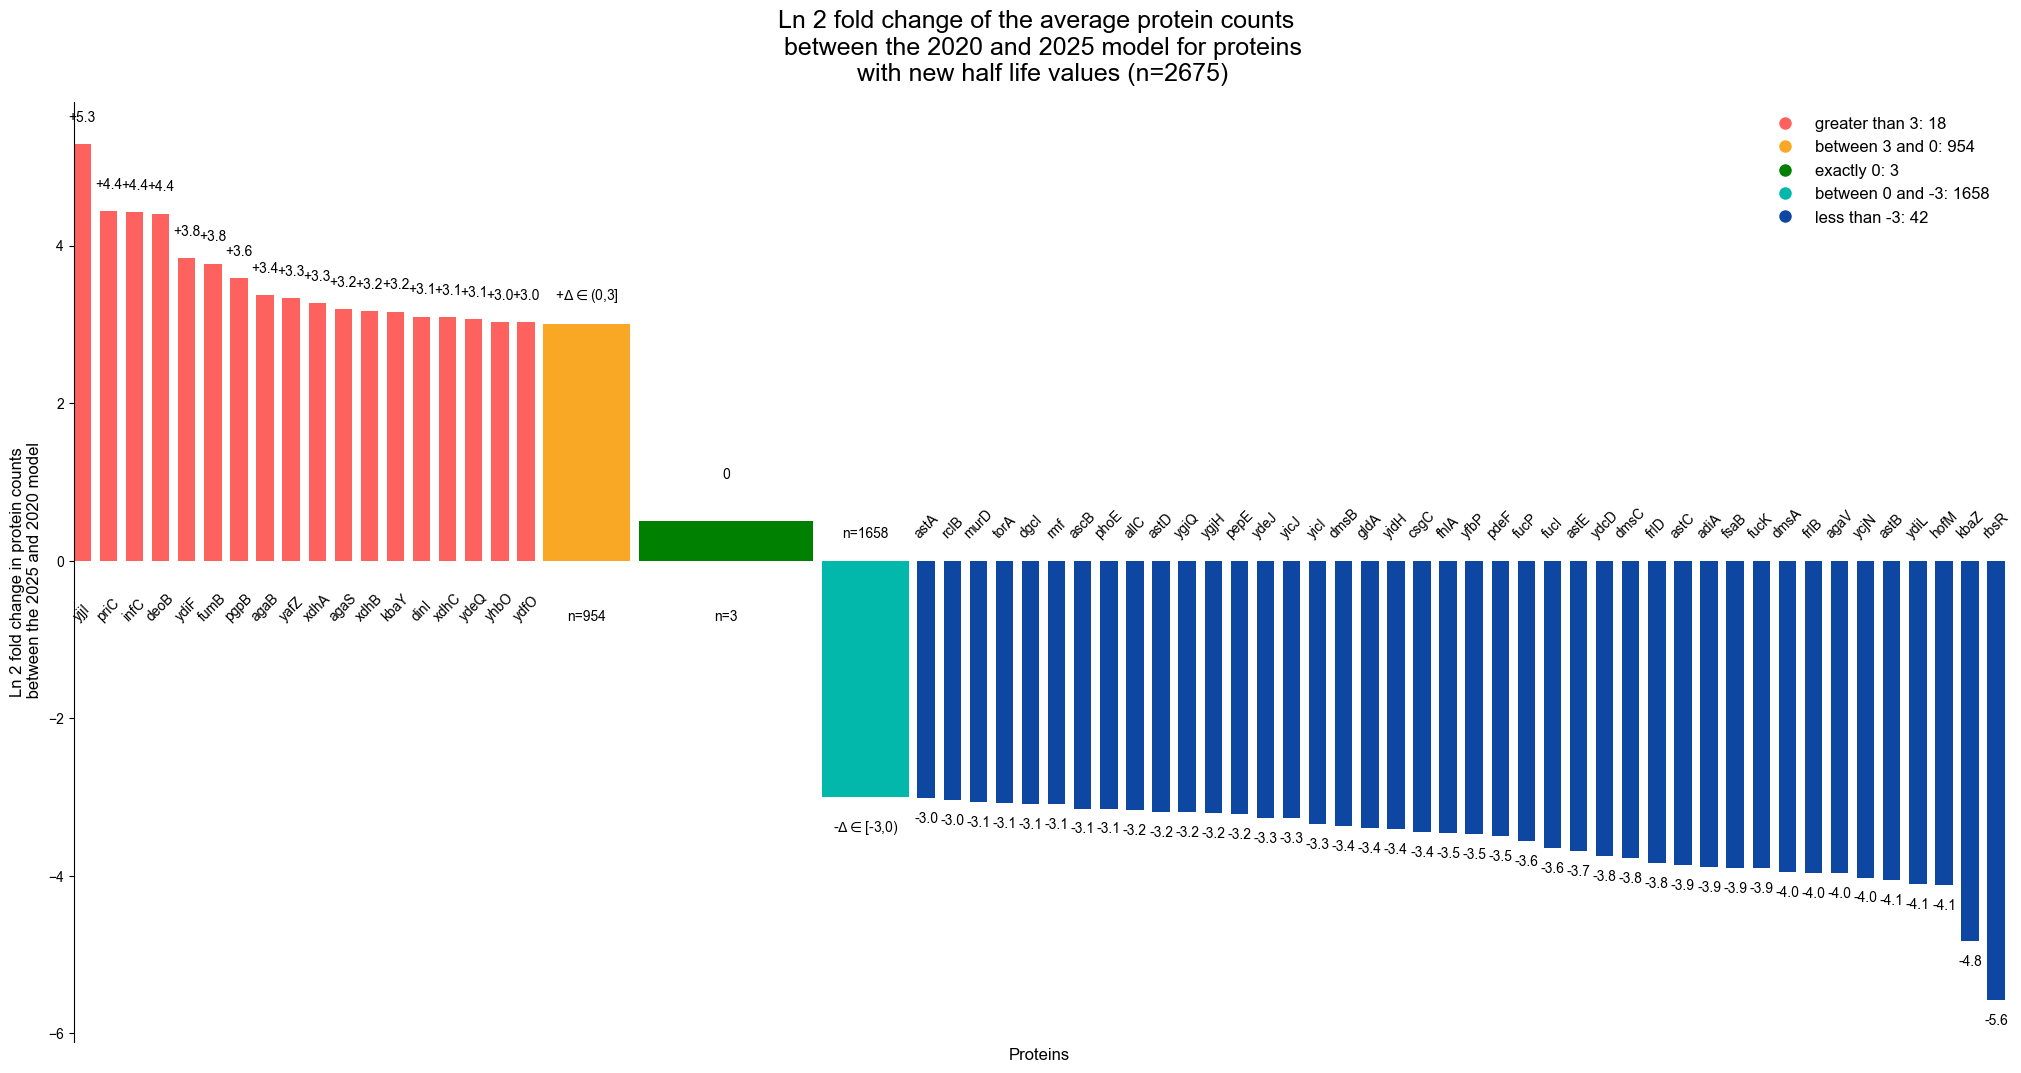

In [194]:
# define the dataframe to plot: 
df = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot: 
column = 'PC_ln2_fold_change'

# define bounds for changes
upper = 3
middle = 0
lower = -3

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/ln2_fold_change_in_protein_count_values_for_proteins_with_new_HL_values_bounds[{lower},{middle},{upper}].png"

# define the title of the plot:
title0 = f'Ln 2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins\n with new half life values (n={df.shape[0]})'


# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Ln 2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   



# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## Plot the ln 2 fold change of the protein counts using only the proteins that had no change in half life from their original value
Prep the data: 

In [195]:
combined_df_of_proteins_with_same_HLs = combined_df.copy()

# remove the proteins that have a different half life value between new_half_life and original_half_life:
combined_df_of_proteins_with_same_HLs = combined_df_of_proteins_with_same_HLs[combined_df_of_proteins_with_same_HLs['HL_difference'] == 0] # should add up to 2675, as I believe that is how many were reassigned to Gupta et al. 2024 data! 

combined_df_of_proteins_with_same_HLs


,monomer_id,new_half_life,original_half_life,common_name,Log10 CLNE_11192024 Average Monomer Counts,Log10 CLClim3NE1 Average Monomer Counts,HL_difference,HL_fold_change,HL_ln2_fold_change,PC_difference,PC_fold_change,PC_ln2_fold_change,counts_new_+10,counts_old_+10,ln2_counts_10
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,600.0,600.0,panE,2.155309,2.321794,0.0,1.0,0.0,66.803382,1.467186,0.553052,2.342016,2.184666,0.100339
19,ABGT-MONOMER,600.0,600.0,abgT,0.496491,1.228946,0.0,1.0,0.0,13.804438,5.400764,2.433164,1.430418,1.118490,0.354884
30,ACPSUB-MONOMER,600.0,600.0,citD,0.000000,0.185914,0.0,1.0,0.0,0.534315,1.534315,0.617594,1.061992,1.041393,0.028258
33,ACRF-MONOMER,600.0,600.0,acrF,0.000000,0.000000,0.0,1.0,0.0,0.000000,1.000000,0.000000,1.041393,1.041393,0.000000
51,AGAC-MONOMER,600.0,600.0,agaC,0.045585,1.085333,0.0,1.0,0.0,11.060515,10.958413,3.453967,1.345789,1.045740,0.363928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4299,YPHE-MONOMER,600.0,600.0,yphE,1.128710,0.952872,0.0,1.0,0.0,-4.477965,0.667056,-0.584120,1.278105,1.370136,-0.100312
4301,YRBE-MONOMER,600.0,600.0,mlaE,2.291749,2.378614,0.0,1.0,0.0,43.347960,1.221422,0.288561,2.396407,2.313385,0.050868
4303,YRBG-MONOMER,600.0,600.0,yrbG,1.438401,1.396331,0.0,1.0,0.0,-2.533531,0.907674,-0.139754,1.542919,1.573348,-0.028176
4306,YTFT-MONOMER,600.0,600.0,ytfT,1.569764,1.138950,0.0,1.0,0.0,-23.362790,0.370840,-1.431131,1.376039,1.673328,-0.282199


Generate the ln2 fold change protein count bar plot:

greater than 4: 22
between 4 and 0: 597
exactly 0: 144
between 0 and -4: 821
less than -4: 51


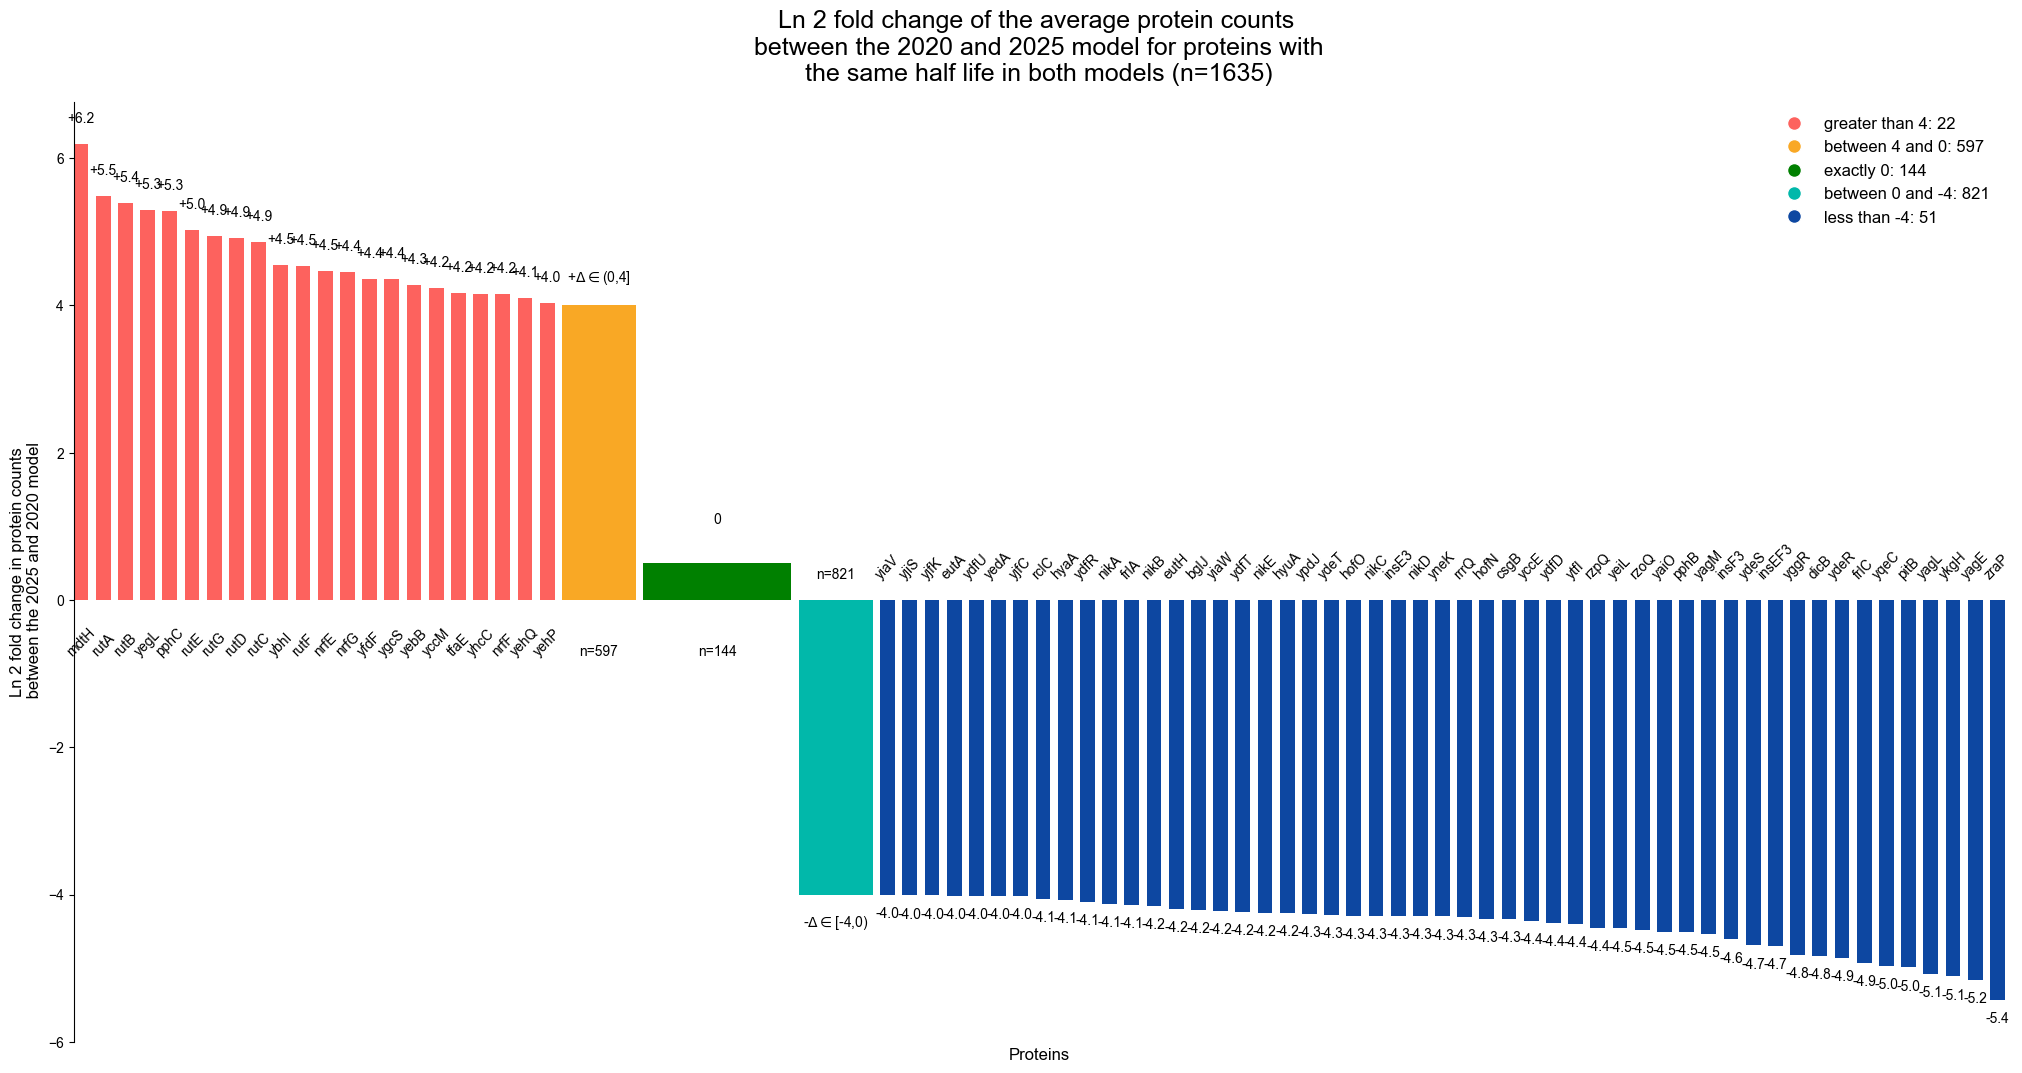

In [196]:
# define the data to use: 
df = combined_df_of_proteins_with_same_HLs.copy()

# define column to plot: 
column = 'PC_ln2_fold_change'

# define bounds for changes
upper = 4
middle = 0
lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/ln2_fold_change_in_protein_count_values_for_proteins_with_no_change_in_HL_bounds[{lower},{middle},{upper}].png"

# define the title of the plot:
title0 = f'Ln 2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# find all of the half lives that are greater than 800:
CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
print(words_u)

# find all the half lives between 800 and 0: 
CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
print(words_u2m)

CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
print(words_m)

# find all half lives between 600 and 200: 
CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
print(words_m2l)

# find all the half lives between 200 and 0:
CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
print(words_l)


# make a new data frame that is more simple
# concatenate the data frames together:
CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]

# add a new rows to the data: 
new_rows = [
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
        column: upper,
        'sort_color': 'orange',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
        column: middle + 0.5,
        'sort_color': 'green',
        'column_width': 4
    },
    {
        'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
        column: lower,
        'sort_color': 'lightblue',
        'column_width': 4
    }
]

# convert new rows to a DataFrame:
new_rows_df = pd.DataFrame(new_rows)
data = pd.concat([data, new_rows_df], ignore_index=True)

# sort the data
data = data.sort_values(by=[column], ascending=False)
data.set_index('common_name', inplace=True)


# create a color dictionary for the colors:
color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}

# create a size dictionary for the sizes:
size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}

upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])

first_ticks = np.ones(upper_len) * size_dict['red']
second_ticks = np.ones(1) * size_dict['orange']
third_ticks = np.ones(1) * size_dict['green']
fourth_ticks = np.ones(1) * size_dict['lightblue']
fifth_ticks = np.ones(lower_len) * size_dict['blue']
col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
col_widths = np.concatenate(col_widths)
col_widths

# GET THE POSITIONS OF THE BARS
# from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
a = 0
x_positions = []
for i in range(len(col_widths)):
    if i == 0:
        a+=col_widths[i]
       
        x_positions.append(col_widths[i]/2)
        
    else:
        a += col_widths[i] + 0.05 # adding a gap 
       
        x_positions.append(a - col_widths[i]/2)

x_positions = np.array(x_positions)

# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
index = data.index
column0 = data[column]

fig, axes = plt.subplots(figsize=(20,10),  nrows=1)
fig.tight_layout()

#axes.bar(index, column0, align='center', color=color_red, zorder=10)
axes.set_title(title0, fontsize=18, pad=15, )


ticks_to_plot = []
for i, val in enumerate(column0):
    axes.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
    if data['sort_color'].iloc[i] == 'red':
        axes.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'blue':
        axes.text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
    if data['sort_color'].iloc[i] == 'green':
        axes.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'orange':
        axes.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$({middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    if data['sort_color'].iloc[i] == 'lightblue':
        axes.text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle})", ha='center', va='bottom', fontsize=10, rotation=0, )
        axes.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )



axes.set_ylabel('Ln 2 fold change in protein counts\n between the 2025 and 2020 model', fontsize=12, color="black", )
axes.set_xlabel('Proteins', fontsize=12, color="black", )
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.set_xticks([])
axes.margins(x=0.0)

#axes.set_ylim(-600, (lower + 2))  # cant do this here, should only do it when I do not have a shared x axis! 

# add a legend: 
#axes.legend(loc='upper right', fontsize=12, frameon=False, markerscale=2)
axes.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)
    ],
    loc='upper right',
    fontsize=12,
    frameon=False,
    markerscale=2
)   



# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Histogram of protein count data

Histogram of all data: 

PC_ln2_fold_change
count    1635.000000
mean       -0.241014
std         1.609680
min        -5.428356
25%        -0.850306
50%        -0.052223
75%         0.345045
max         6.186902
Name: PC_ln2_fold_change, dtype: float64


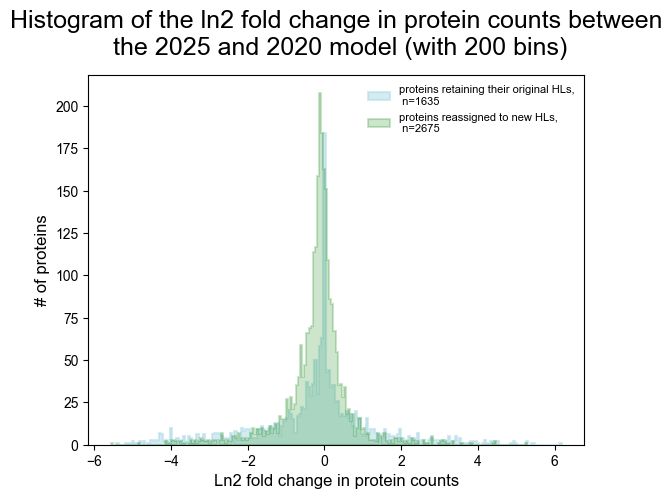

In [197]:
# make a histogram of the ln2 fold change for protein counts: 

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'PC_ln2_fold_change'
bins = 200

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_ln2_fold_change_in_protein_count_values_bins[{bins}].png"

# define the title of the plot:
title0 = f'Histogram of the ln2 fold change in protein counts between\n the 2025 and 2020 model (with {bins} bins)' 

plt.hist(df1[column], histtype='stepfilled',bins=bins, color='lightblue', alpha=0.5, label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='lightblue', linewidth=1.5)
plt.hist(df2[column], bins=bins,histtype='stepfilled',  color='green', alpha=0.2, label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='green', linewidth=1.5) 

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Ln2 fold change in protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)


# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

print(column)
print(df1[column].describe())

Same as above, but with bounds to see closer. 
NOTE: the plot will look different, because I am still using 100 bins but on a plot with a smaller x axis range, so there will be more split up of the values.

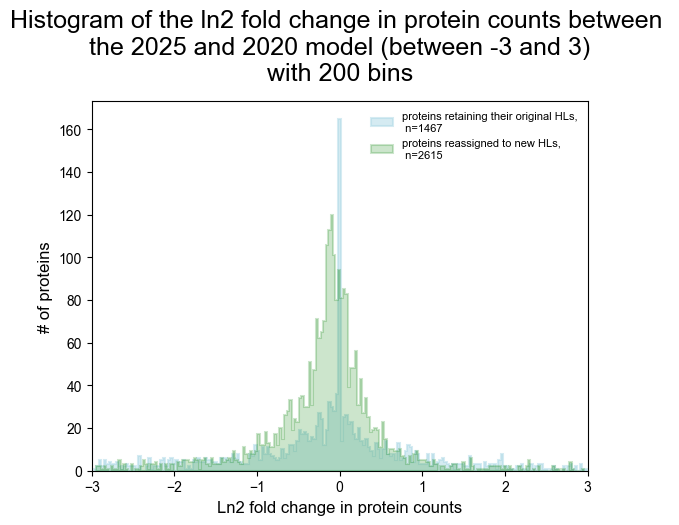

In [198]:
# make a histogram of the ln2 fold change for protein counts: 

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'PC_ln2_fold_change'

# define bounds for changes
upper = 3
lower = -3
bins = 200

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_ln2_fold_change_in_protein_count_values_xbounds[{lower},{upper}]_bins[{bins}].png"

# define the title of the plot:
title0 = f'Histogram of the ln2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper})\nwith {bins} bins'

# take out the values that are above the upper bound:
df1 = df1[df1[column] < upper]
df2 = df2[df2[column] < upper]
# take out the values that are below the lower bound:
df1 = df1[df1[column] > lower]
df2 = df2[df2[column] > lower]

# make the histogram:
plt.hist(df1[column], histtype='stepfilled', bins=bins, color='lightblue', alpha=0.5,
         label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='lightblue', linewidth=1.5)
plt.hist(df2[column], bins=bins, histtype='stepfilled', color='green', alpha=0.2,
         label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='green', linewidth=1.5)

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Ln2 fold change in protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.xlim(lower, upper)
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


same as above but using seaborn:

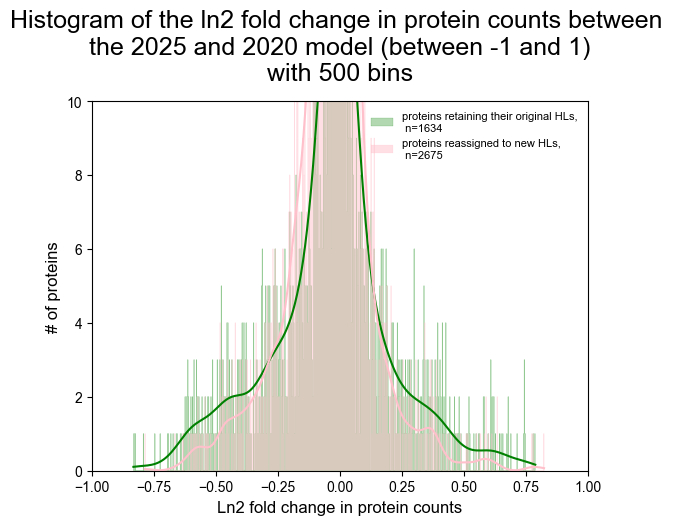

In [207]:
# make a histogram of the ln2 fold change for protein counts: 
import seaborn as sns

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'ln2_counts_10'

# define bounds for changes
upper = 1
lower = -1
bins = 500

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_ln2_fold_change_in_protein_count_values_using_sns_xbounds[{lower},{upper}]_bins[{bins}].png"

# define the title of the plot:
# define the title of the plot:
title0 = f'Histogram of the ln2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper})\nwith {bins} bins'

# take out the values that are above the upper bound:
df1 = df1[df1[column] < upper]
df2 = df2[df2[column] < upper]
# take out the values that are below the lower bound:
df1 = df1[df1[column] > lower]
df2 = df2[df2[column] > lower]

# make the histogram:
sns.histplot(df1[column],  bins=bins, color='green', alpha=0.3, kde=True, element='step',
         label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='green', linewidth=.1)
sns.histplot(df2[column], bins=bins,  color='pink', alpha=0.5, kde=True, element='step',
         label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='pink', linewidth=.1)

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Ln2 fold change in protein counts', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.xlim(lower, upper)
plt.ylim(0, 10)
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


# Histogram of half life data

HL_ln2_fold_change
count    2675.000000
mean       -0.354991
std         1.031811
min        -9.725345
25%        -0.597319
50%        -0.048343
75%         0.189010
max         8.870018
Name: HL_ln2_fold_change, dtype: float64


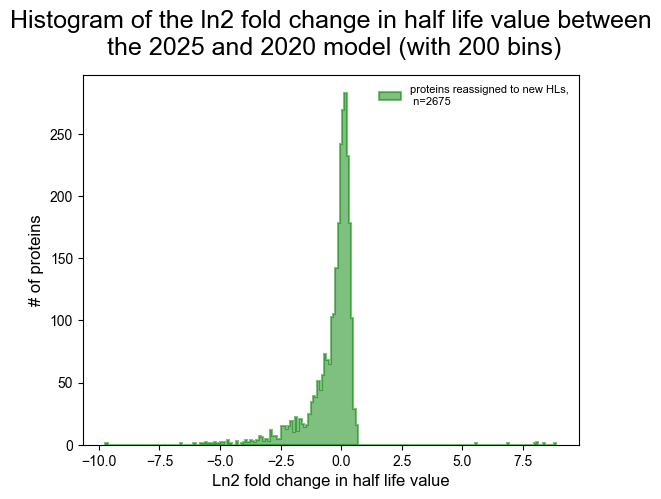

In [200]:
# make a histogram of the ln2 fold change for protein counts: 

# define the data to use:
df1 = combined_df_of_proteins_with_same_HLs.copy()
df2 = combined_df_of_proteins_with_new_HLs.copy()

# define column to plot:
column = 'HL_ln2_fold_change'
bins = 200

# define the name of the file:
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/histogram_of_ln2_fold_change_in_half_life_values_bins[{bins}].png"

# define the title of the plot:
title0 = f'Histogram of the ln2 fold change in half life value between\n the 2025 and 2020 model (with {bins} bins)' 

#plt.hist(df1[column], histtype='stepfilled',bins=bins, color='lightblue', alpha=0.5, label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='lightblue', linewidth=1.5)
plt.hist(df2[column], bins=bins,histtype='stepfilled',  color='green', alpha=0.5, label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='green', linewidth=1.5) 

plt.title(title0, fontsize=18, pad=15, )
plt.xlabel('Ln2 fold change in half life value', fontsize=12, color="black", )
plt.ylabel('# of proteins', fontsize=12, color="black", )
plt.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)


# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

print(column)
print(df2[column].describe())

# Matrix!


HL_ln2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_ln2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_ln2_fold_change
count    4310.000000
mean       -0.210582
std         1.209696
min        -5.571395
25%        -0.511648
50%        -0.095681
75%         0.175957
max         6.186902
Name: PC_ln2_fold_change, dtype: float64
greater than 4: 26
between 4 and 0: 1565
exactly 0: 147
between 0 and -4: 2515
less than -4: 57
HL_ln2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_ln2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_ln2_fold_change
count    

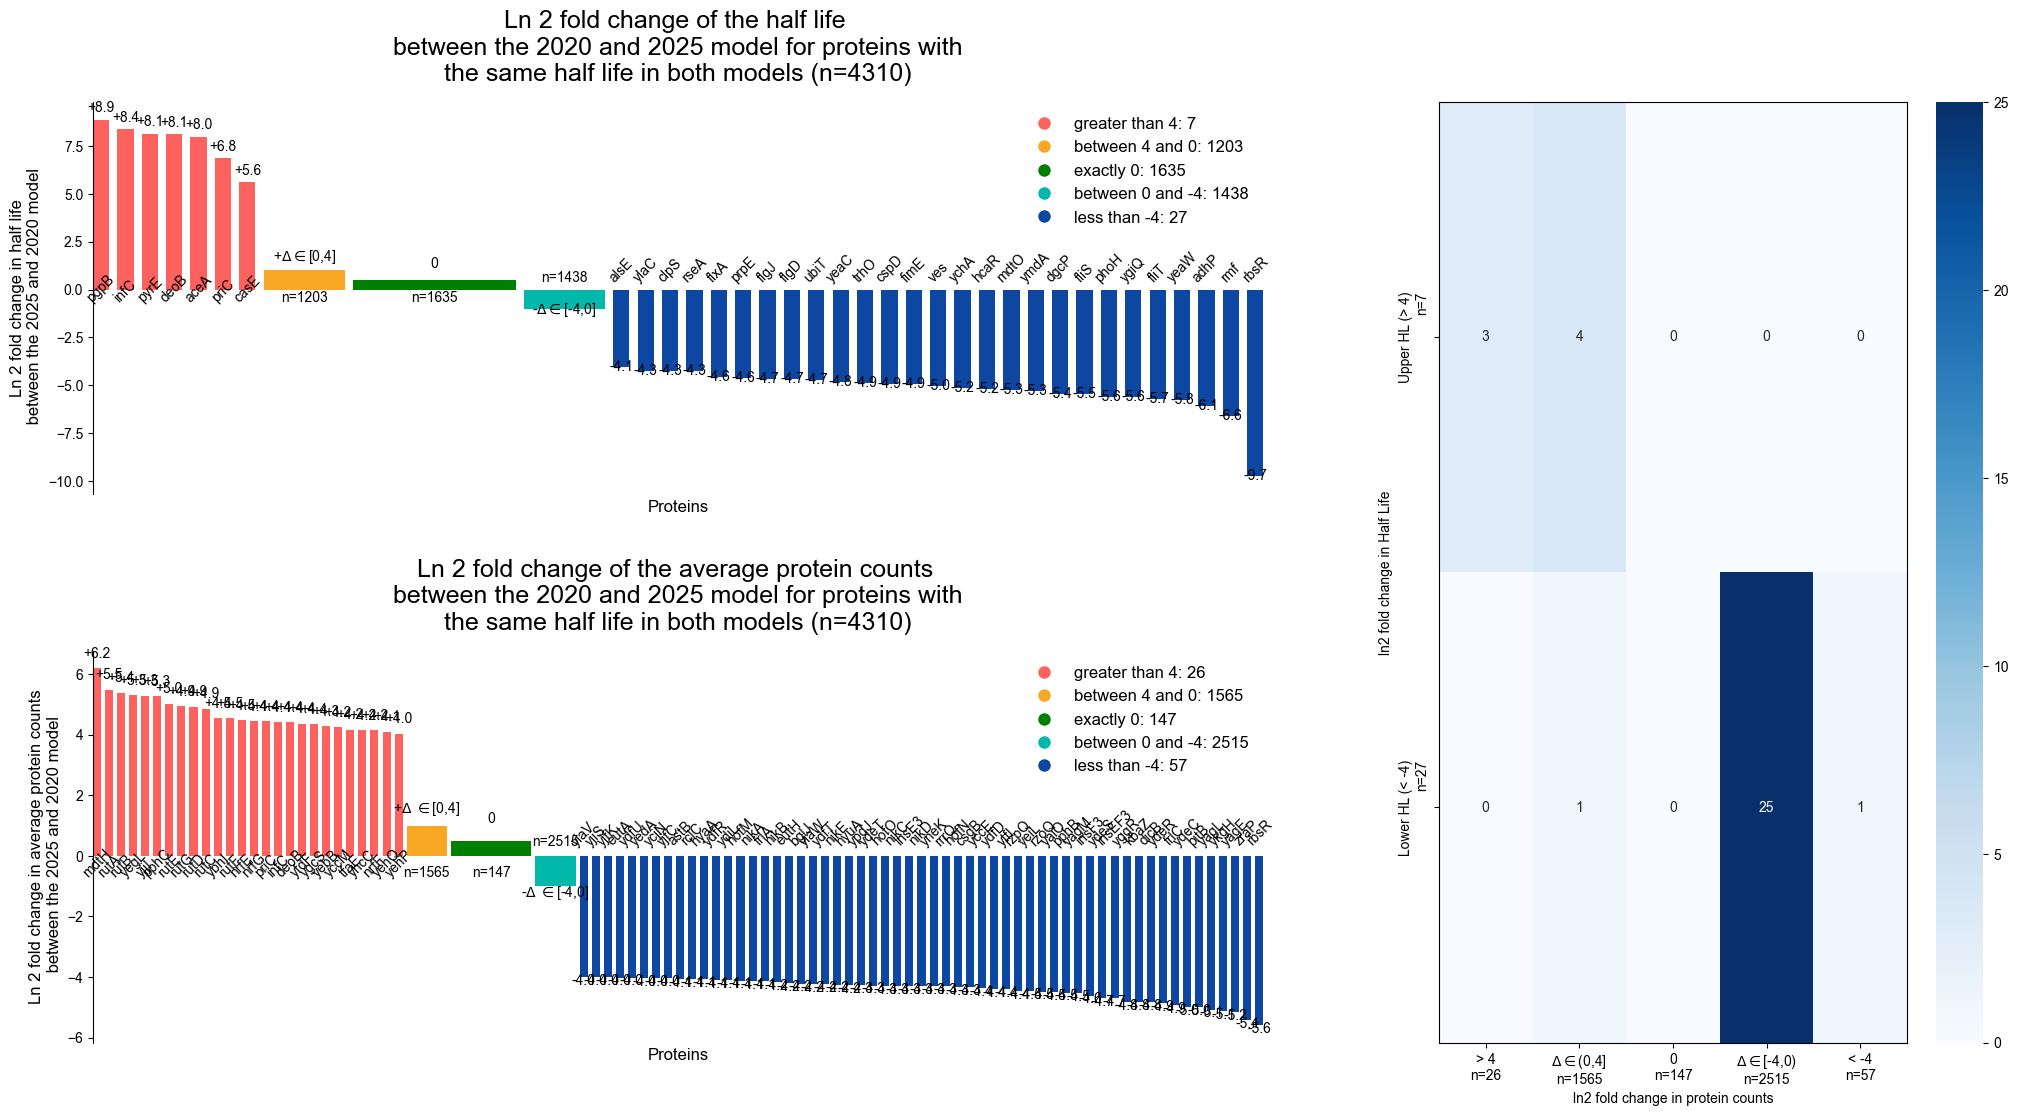

In [209]:
# time to make subplots! 

# define the data to use: 
df = combined_df.copy()

# define columns to plot: 
column0 = 'HL_ln2_fold_change'
column1 = 'PC_ln2_fold_change'

# define the title of the plot:
title0 = f'Ln 2 fold change of the half life \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'
title1 = f'Ln 2 fold change of the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# define bounds for changes in half lives:
HL_upper = 4
HL_middle = 0
HL_lower = -4

# define bounds for changes in protein counts:
PC_upper = 4
PC_middle = 0
PC_lower = -4

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/ln2_fold_change_in_HL_and_PC_values_for_all_proteins__HL_bounds[{HL_lower},{HL_middle},{HL_upper}]__PC_bounds[{PC_lower},{PC_middle},{PC_upper}]__with_matrix.png"


def obtain_data(df, column, upper, middle, lower):
    print(column)
    print(df[column].describe())
    # find all of the half lives that are greater than 800:
    CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
    CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
    CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
    CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
    words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
    print(words_u)
    
    # find all the half lives between 800 and 0: 
    CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
    CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
    CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
    CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
    words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
    print(words_u2m)
    
    CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
    CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
    CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
    CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
    words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
    print(words_m)
    
    # find all half lives between 600 and 200: 
    CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
    CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
    CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
    CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
    words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
    print(words_m2l)
    
    # find all the half lives between 200 and 0:
    CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
    CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
    CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
    CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
    words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
    print(words_l)

    return(CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l)



def clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower):
    # make a new data frame that is more simple
    # concatenate the data frames together:
    CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
    data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]
    
    # add a new rows to the data: 
    new_rows = [
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
            column: upper,
            'sort_color': 'orange',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
            column: middle + 0.5,
            'sort_color': 'green',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
            column: lower,
            'sort_color': 'lightblue',
            'column_width': 4
        }
    ]
    
    # convert new rows to a DataFrame:
    new_rows_df = pd.DataFrame(new_rows)
    data = pd.concat([data, new_rows_df], ignore_index=True)
    
    # sort the data
    data = data.sort_values(by=[column], ascending=False)
    data.set_index('common_name', inplace=True)

    # create a color dictionary for the colors:
    color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}
    
    # create a size dictionary for the sizes:
    size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}
    
    upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
    lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])
    
    first_ticks = np.ones(upper_len) * size_dict['red']
    second_ticks = np.ones(1) * size_dict['orange']
    third_ticks = np.ones(1) * size_dict['green']
    fourth_ticks = np.ones(1) * size_dict['lightblue']
    fifth_ticks = np.ones(lower_len) * size_dict['blue']
    col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
    col_widths = np.concatenate(col_widths)
    col_widths
    
    # GET THE POSITIONS OF THE BARS
    # from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
    a = 0
    x_positions = []
    for i in range(len(col_widths)):
        if i == 0:
            a+=col_widths[i]
           
            x_positions.append(col_widths[i]/2)
            
        else:
            a += col_widths[i] + 0.05 # adding a gap 
           
            x_positions.append(a - col_widths[i]/2)
    
    x_positions = np.array(x_positions)
    
    return data, x_positions, col_widths, color_dict, size_dict



def make_subplot(row, col, df, column, variable, upper, middle, lower, title,):
    CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, upper, middle, lower)
    
    data, x_positions, col_widths, color_dict, size_dict = clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower)
    
    # begin the plot:
    index = data.index
    
    # use the if row statement to tune the values added to the val varioable for each plot (as these may need to change depending on the bounds): 
    if column == 'HL_ln2_fold_change':
        for i, val in enumerate(data[column]):
            axes[row, col].bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                axes[row, col].text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                axes[row, col].text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                axes[row, col].text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                axes[row, col].text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                axes[row, col].text(x_positions[i], val - .5, f"-$\\Delta$$\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
                
    else:
        for i, val in enumerate(data[column]):
            axes[row, col].bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                axes[row, col].text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                axes[row, col].text(x_positions[i], val - 0.35, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                axes[row, col].text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                axes[row, col].text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                axes[row, col].text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                axes[row, col].text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    
    # plot specifications:
    ax = axes[row, col]
    ax.set_title(title, fontsize=18, pad=15, )
    ax.set_ylabel(f'Ln 2 fold change in {variable}\n between the 2025 and 2020 model', fontsize=12, color="black", )
    ax.set_xlabel('Proteins', fontsize=12, color="black", )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.margins(x=0.0)


    ax.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)],
        loc='upper right', fontsize=12, frameon=False, markerscale=2)   



def find_inputs(input_df, u_output_df, u2m_output_df, m_output_df, m2l_output_df, l_output_df):
    #find where the common names in the input_df show up in the output df(s)
    in_u_output_df = input_df[input_df['common_name'].isin(u_output_df['common_name'])]
    in_u2m_output_df = input_df[input_df['common_name'].isin(u2m_output_df['common_name'])]
    in_m_output_df = input_df[input_df['common_name'].isin(m_output_df['common_name'])]
    in_m2l_output_df = input_df[input_df['common_name'].isin(m2l_output_df['common_name'])]
    in_l_output_df = input_df[input_df['common_name'].isin(l_output_df['common_name'])]
    
    # find the number of common names in each output df:
    u_count = in_u_output_df.shape[0]
    u2m_count = in_u2m_output_df.shape[0]
    m_count = in_m_output_df.shape[0]
    m2l_count = in_m2l_output_df.shape[0]
    l_count = in_l_output_df.shape[0]
    
    # create a dictionary of the counts:
    counts = {
        'u': u_count,
        'u2m': u2m_count,
        'm': m_count,
        'm2l': m2l_count,
        'l': l_count}
    
    return counts

# next, make a confusion matrix of the data:
def make_matrix(row, col, df, column0, column1, upper_HL, middle_HL, lower_HL, upper_PC, middle_PC, lower_PC):
    # make a confusion matrix of the data:
    HL_u, HL_u2m, HL_m, HL_m2l, HL_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column0, upper_HL, middle_HL, lower_HL)
    
    PC_u, PC_u2m, PC_m, PC_m2l, PC_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column1, upper_PC, middle_PC, lower_PC)
    
    # find the counts of the common names in each output df:
    counts1 = find_inputs(HL_u, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts2 = find_inputs(HL_l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    
    # make the matrix: 
    matrix_df = pd.DataFrame([
    [counts1['u'], counts1['u2m'], counts1['m'], counts1['m2l'], counts1['l']],
    [counts2['u'], counts2['u2m'], counts2['m'], counts2['m2l'], counts2['l']]  
    ], index=[f'Upper HL (> {upper_HL})\nn={HL_u.shape[0]}', f'Lower HL (< {lower_HL})\nn={HL_l.shape[0]}'],
   columns=[f'> {upper_PC}\nn={PC_u.shape[0]}', f'$\\Delta$$\\in$({middle_PC},{upper_PC}]\nn={PC_u2m.shape[0]}', f'{middle_PC}\nn={PC_m.shape[0]}', f'$\\Delta$$\\in$[{lower_PC},{middle_PC})\nn={PC_m2l.shape[0]}', f'< {lower_PC}\nn={PC_l.shape[0]}'])
     
    # make the heatmap take up the whole right side: 
    from matplotlib import gridspec
    fig.delaxes(axes[0, 1]) # delete the third axes
    fig.delaxes(axes[1, 1]) # delete the fourth axes 
    gridspecs = axes[0,0].get_gridspec() # get the gridspecs of the other axes
    axes_matrix = fig.add_subplot(gridspecs[:, 1]) # add a new axes to the gridspecs
    ax = axes_matrix
    
    # plot the matrix:
    sns.heatmap(matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    # plot specs: 
    ax.set_xlabel('ln2 fold change in protein counts')
    ax.set_ylabel('ln2 fold change in Half Life')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(20,10),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [2, 1]})
fig.tight_layout()

# plot the plots 
make_subplot(0, 0, df, column0, 'half life', HL_upper, HL_middle, HL_lower, title0)
make_subplot(1, 0, df, column1, 'average protein counts', PC_upper, PC_middle, PC_lower, title1)
make_matrix(0, 1, df, column0, column1, HL_upper, HL_middle, HL_lower, PC_upper, PC_middle, PC_lower)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')


## try also adding the histogram

HL_ln2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_ln2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_ln2_fold_change
count    4310.000000
mean       -0.210582
std         1.209696
min        -5.571395
25%        -0.511648
50%        -0.095681
75%         0.175957
max         6.186902
Name: PC_ln2_fold_change, dtype: float64
greater than 4.5: 12
between 4.5 and 0: 1579
exactly 0: 147
between 0 and -4: 2515
less than -4: 57
HL_ln2_fold_change
count    4310.000000
mean       -0.220325
std         0.830872
min        -9.725345
25%        -0.188968
50%         0.000000
75%         0.049786
max         8.870018
Name: HL_ln2_fold_change, dtype: float64
greater than 4: 7
between 4 and 0: 1203
exactly 0: 1635
between 0 and -4: 1438
less than -4: 27
PC_ln2_fold_change
count

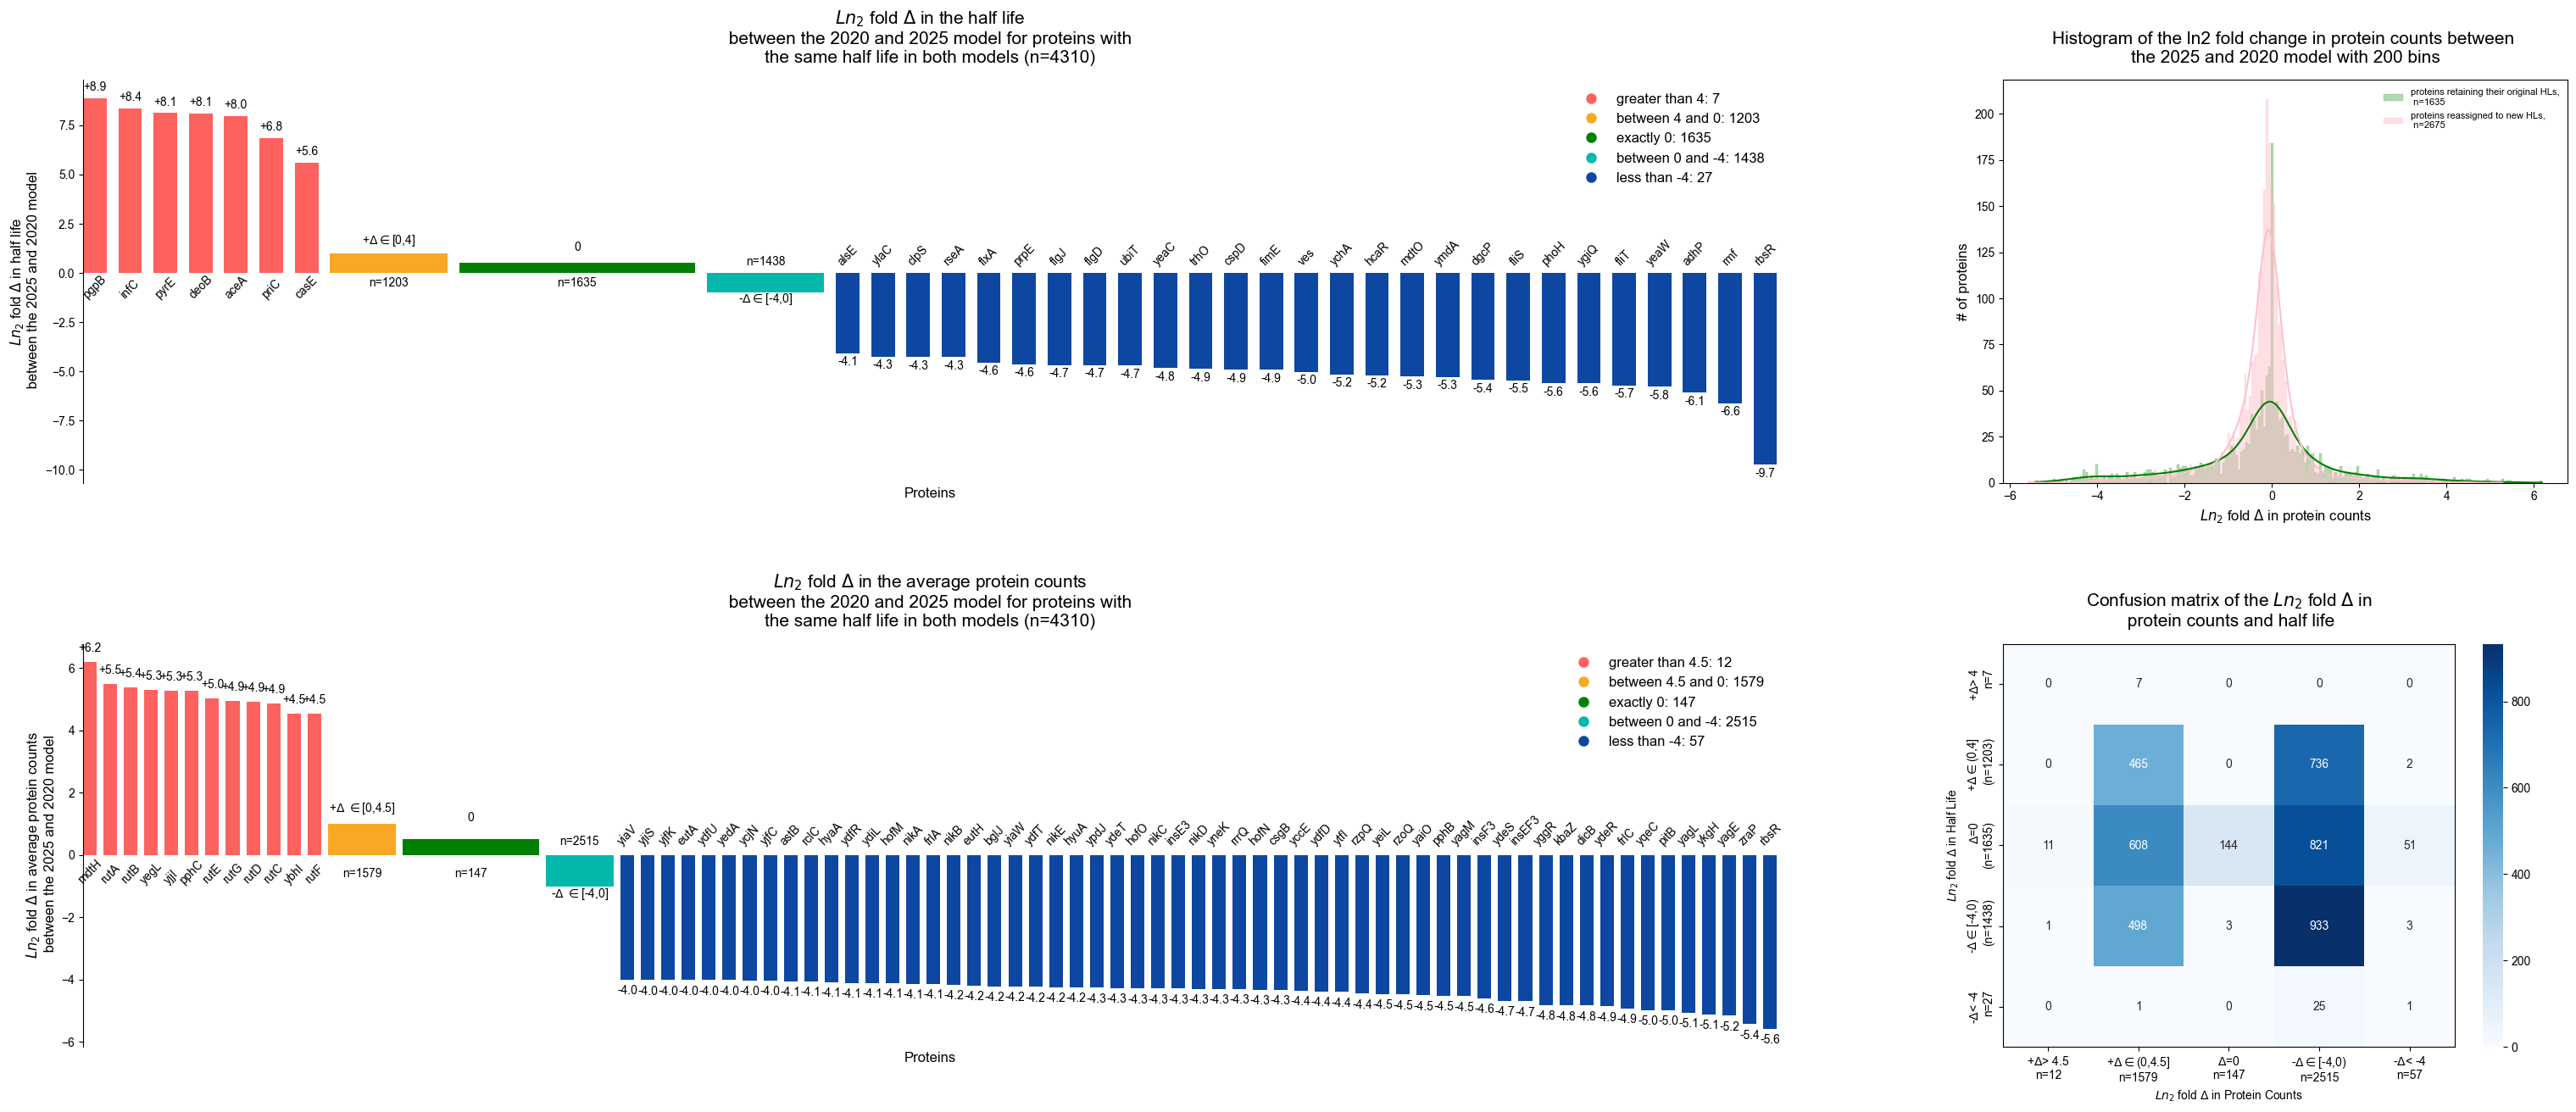

In [218]:
# time to make subplots! 

# define the data to use: 
df = combined_df.copy()

# define columns to plot: 
column0 = 'HL_ln2_fold_change'
column1 = 'PC_ln2_fold_change'

# define the title of the plot:
title0 = f'$Ln_{2}$ fold $\\Delta$ in the half life \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'
title1 = f'$Ln_{2}$ fold $\\Delta$ in the average protein counts \n between the 2020 and 2025 model for proteins with \nthe same half life in both models (n={df.shape[0]})'

# define bounds for changes in half lives:
HL_upper = 4
HL_middle = 0
HL_lower = -4

# define bounds for changes in protein counts:
PC_upper = 4.5
PC_middle = 0
PC_lower = -4

# define column to plot in the histogram:
column_histogram = 'PC_ln2_fold_change'
# define bounds for changes in the histogram
upper_histogram = None
lower_histogram = None
bins_histogram = 200

# define the name of the file: 
out_pth = f"out/figures/PDR_UPDATE_MERGE/F2/change_in_half_life_histograms/ln2_fold_change_in_HL_and_PC_values_for_all_proteins__HL_bounds[{HL_lower},{HL_middle},{HL_upper}]__PC_bounds[{PC_lower},{PC_middle},{PC_upper}]__histogram_xbounds[{upper_histogram},{lower_histogram}]_xbins[{bins_histogram}]__with_matrix.png"


def obtain_data(df, column, upper, middle, lower):
    print(column)
    print(df[column].describe())
    # find all of the half lives that are greater than 800:
    CLClim3NE1_HLs_Clim3_above_upper = df[df[column] > upper] # 
    CLClim3NE1_HLs_Clim3_above_upper = CLClim3NE1_HLs_Clim3_above_upper.copy()
    CLClim3NE1_HLs_Clim3_above_upper["sort_color"] = "red"
    CLClim3NE1_HLs_Clim3_above_upper["column_width"] = "1"
    words_u = f'greater than {upper}: {CLClim3NE1_HLs_Clim3_above_upper.shape[0]}'
    print(words_u)
    
    # find all the half lives between 800 and 0: 
    CLClim3NE1_HLs_Clim3_upper_to_zero = df[(df[column] <= upper) & (df[column] > middle)] # 
    CLClim3NE1_HLs_Clim3_upper_to_zero = CLClim3NE1_HLs_Clim3_upper_to_zero.copy()
    CLClim3NE1_HLs_Clim3_upper_to_zero["sort_color"] = "orange"
    CLClim3NE1_HLs_Clim3_upper_to_zero["column_width"] = "4"
    words_u2m = f'between {upper} and {middle}: {CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}'
    print(words_u2m)
    
    CLClim3NE1_HLs_Clim3_middle = df[df[column] == middle ] #
    CLClim3NE1_HLs_Clim3_middle = CLClim3NE1_HLs_Clim3_middle.copy()
    CLClim3NE1_HLs_Clim3_middle["sort_color"] = "green"
    CLClim3NE1_HLs_Clim3_middle["column_width"] = "4"
    words_m = f'exactly {middle}: {CLClim3NE1_HLs_Clim3_middle.shape[0]}'
    print(words_m)
    
    # find all half lives between 600 and 200: 
    CLClim3NE1_HLs_Clim3_0_to_lower = df[(df[column] < middle) & (df[column] > lower)] # 
    CLClim3NE1_HLs_Clim3_0_to_lower = CLClim3NE1_HLs_Clim3_0_to_lower.copy()
    CLClim3NE1_HLs_Clim3_0_to_lower["sort_color"] = "lightblue"
    CLClim3NE1_HLs_Clim3_0_to_lower["column_width"] = "4"
    words_m2l = f'between {middle} and {lower}: {CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}'
    print(words_m2l)
    
    # find all the half lives between 200 and 0:
    CLClim3NE1_HLs_Clim3_lower = df[(df[column] <= lower)] # 
    CLClim3NE1_HLs_Clim3_lower = CLClim3NE1_HLs_Clim3_lower.copy()
    CLClim3NE1_HLs_Clim3_lower["sort_color"] = "blue"
    CLClim3NE1_HLs_Clim3_lower["column_width"] = "1"
    words_l = f'less than {lower}: {CLClim3NE1_HLs_Clim3_lower.shape[0]}'
    print(words_l)

    return(CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l)



def clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower):
    # make a new data frame that is more simple
    # concatenate the data frames together:
    CLClim3NE1_HLs_Clim3_split_protein_difference = pd.concat([CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_lower], ignore_index=True)
    data = CLClim3NE1_HLs_Clim3_split_protein_difference[['common_name', column,'sort_color', 'column_width']]
    
    # add a new rows to the data: 
    new_rows = [
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_upper_to_zero.shape[0]}',
            column: upper,
            'sort_color': 'orange',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_middle.shape[0]}',
            column: middle + 0.5,
            'sort_color': 'green',
            'column_width': 4
        },
        {
            'common_name': f'n={CLClim3NE1_HLs_Clim3_0_to_lower.shape[0]}',
            column: lower,
            'sort_color': 'lightblue',
            'column_width': 4
        }
    ]
    
    # convert new rows to a DataFrame:
    new_rows_df = pd.DataFrame(new_rows)
    data = pd.concat([data, new_rows_df], ignore_index=True)
    
    # sort the data
    data = data.sort_values(by=[column], ascending=False)
    data.set_index('common_name', inplace=True)

    # create a color dictionary for the colors:
    color_dict = {'red': '#fd625e', 'orange': '#f9a825', 'green': 'green', 'lightblue': '#01b8aa', 'blue': '#0d47a1'}
    
    # create a size dictionary for the sizes:
    size_dict = {'red': .1, 'orange': .5, 'green':1,'lightblue': .5, 'blue': .1}
    
    upper_len = int(CLClim3NE1_HLs_Clim3_above_upper.shape[0])
    lower_len = int(CLClim3NE1_HLs_Clim3_lower.shape[0])
    
    first_ticks = np.ones(upper_len) * size_dict['red']
    second_ticks = np.ones(1) * size_dict['orange']
    third_ticks = np.ones(1) * size_dict['green']
    fourth_ticks = np.ones(1) * size_dict['lightblue']
    fifth_ticks = np.ones(lower_len) * size_dict['blue']
    col_widths = [first_ticks, second_ticks, third_ticks, fourth_ticks, fifth_ticks]
    col_widths = np.concatenate(col_widths)
    
    # GET THE POSITIONS OF THE BARS
    # from: https://stackoverflow.com/questions/70477458/how-can-i-plot-bar-plots-with-variable-widths-but-without-gaps-in-python-and-ad
    a = 0
    x_positions = []
    for i in range(len(col_widths)):
        if i == 0:
            a+=col_widths[i]
           
            x_positions.append(col_widths[i]/2)
            
        else:
            a += col_widths[i] + 0.05 # adding a gap 
           
            x_positions.append(a - col_widths[i]/2)
    
    x_positions = np.array(x_positions)
    
    return data, x_positions, col_widths, color_dict, size_dict



def make_subplot(row, col, df, column, variable, upper, middle, lower, title,):
    CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column, upper, middle, lower)
    
    data, x_positions, col_widths, color_dict, size_dict = clean_data(column, CLClim3NE1_HLs_Clim3_above_upper, CLClim3NE1_HLs_Clim3_upper_to_zero, CLClim3NE1_HLs_Clim3_middle, CLClim3NE1_HLs_Clim3_0_to_lower, CLClim3NE1_HLs_Clim3_lower)
    
    # begin the plot:
    index = data.index
    ax = axes[row, col]
    
    # use the if row statement to tune the values added to the val varioable for each plot (as these may need to change depending on the bounds): 
    if column == 'HL_ln2_fold_change':
        for i, val in enumerate(data[column]):
            ax.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                ax.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 1.4, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                ax.text(x_positions[i], val - 0.75, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                ax.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                ax.text(x_positions[i], val + 0.25, f"+$\\Delta$$\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                ax.text(x_positions[i], val - .7, f"-$\\Delta$$\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
                
    else:
        for i, val in enumerate(data[column]):
            ax.bar(x_positions[i], val, color=color_dict[data['sort_color'].iloc[i]], width=size_dict[data['sort_color'].iloc[i]])
            if data['sort_color'].iloc[i] == 'red':
                ax.text(x_positions[i], val + 0.25, f"+{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 1, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'blue':
                ax.text(x_positions[i], val - 0.55, f"{val:.1f}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=45, )
            if data['sort_color'].iloc[i] == 'green':
                ax.text(x_positions[i], val + 0.5, f"{middle}", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'orange':
                ax.text(x_positions[i], val + 0.25, f"+$\\Delta$ $\\in$[{middle},{upper}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 - 0.8, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
            if data['sort_color'].iloc[i] == 'lightblue':
                ax.text(x_positions[i], val - .5, f"-$\\Delta$ $\\in$[{lower},{middle}]", ha='center', va='bottom', fontsize=10, rotation=0, )
                ax.text(x_positions[i], 0 + 0.25, f"{index[i]}", ha='center', va='bottom', fontsize=10, rotation=0, )
    
    # plot specifications:
    ax.set_title(title, fontsize=15, pad=15, )
    ax.set_ylabel(f'$Ln_{2}$ fold $\\Delta$ in {variable}\n between the 2025 and 2020 model', fontsize=12, color="black", )
    ax.set_xlabel('Proteins', fontsize=12, color="black", )
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.margins(x=0.0)


    ax.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=words_u, markerfacecolor=color_dict['red'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_u2m, markerfacecolor=color_dict['orange'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m, markerfacecolor=color_dict['green'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_m2l, markerfacecolor=color_dict['lightblue'], markersize=5),
            plt.Line2D([0], [0], marker='o', color='w', label=words_l, markerfacecolor=color_dict['blue'], markersize=5)],
        loc='upper right', fontsize=12, frameon=False, markerscale=2)   



def find_inputs(input_df, u_output_df, u2m_output_df, m_output_df, m2l_output_df, l_output_df):
    #find where the common names in the input_df show up in the output df(s)
    in_u_output_df = input_df[input_df['common_name'].isin(u_output_df['common_name'])]
    in_u2m_output_df = input_df[input_df['common_name'].isin(u2m_output_df['common_name'])]
    #print(in_u2m_output_df)
    in_m_output_df = input_df[input_df['common_name'].isin(m_output_df['common_name'])]
    in_m2l_output_df = input_df[input_df['common_name'].isin(m2l_output_df['common_name'])]
    in_l_output_df = input_df[input_df['common_name'].isin(l_output_df['common_name'])]
    
    # find the number of common names in each output df:
    u_count = in_u_output_df.shape[0]
    u2m_count = in_u2m_output_df.shape[0]
    m_count = in_m_output_df.shape[0]
    m2l_count = in_m2l_output_df.shape[0]
    l_count = in_l_output_df.shape[0]
    
    # create a dictionary of the counts:
    counts = {
        'u': u_count,
        'u2m': u2m_count,
        'm': m_count,
        'm2l': m2l_count,
        'l': l_count}
    
    return counts

def make_histogram(row, col, df, column, bins, upper=None, lower=None):
    # make a histogram of the ln2 fold change for protein counts: 
    ax = axes[row, col]
    import seaborn as sns
    
    # define the data to use:    
    combined_df_of_proteins_with_same_HLs = df[df['HL_difference'] == 0]
    combined_df_of_proteins_with_new_HLs = df[df['HL_difference'] != 0]
    df1 = combined_df_of_proteins_with_same_HLs.copy()
    df2 = combined_df_of_proteins_with_new_HLs.copy()
    
    # define the title of the plot:
    if upper == None and lower == None:
        title = f'Histogram of the ln2 fold change in protein counts between \nthe 2025 and 2020 model with {bins} bins'
    else:
        # take out the values that are above the upper bound:
        df1 = df1[df1[column] < upper]
        df2 = df2[df2[column] < upper]
        # take out the values that are below the lower bound:
        df1 = df1[df1[column] > lower]
        df2 = df2[df2[column] > lower]
        # get the size of the data:
        num = df1.shape[0] + df2.shape[0]
        title = f'Histogram of the ln2 fold change in protein counts between \nthe 2025 and 2020 model (between {lower} and {upper}, n={num})\nwith {bins} bins'
        
    
    
    # make the histogram:
    sns.histplot(df1[column],  bins=bins, color='green', alpha=0.3, kde=True, element='step',
             label=f'proteins retaining their original HLs,\n n={df1.shape[0]}', edgecolor='green', linewidth=.1, ax=ax)
    sns.histplot(df2[column], bins=bins,  color='pink', alpha=0.5, kde=True, element='step',
             label=f'proteins reassigned to new HLs,\n n={df2.shape[0]}', edgecolor='pink', linewidth=.1, ax=ax)
    
    ax.set_title(title, fontsize=15, pad=15, )
    ax.set_xlabel(f'$Ln_{2}$ fold $\\Delta$ in protein counts', fontsize=12, color="black", )
    ax.set_ylabel('# of proteins', fontsize=12, color="black", )
    ax.legend(loc='upper right', fontsize=8, frameon=False, markerscale=2)
    


# next, make a confusion matrix of the data:
def make_matrix(row, col, df, column0, column1, upper_HL, middle_HL, lower_HL, upper_PC, middle_PC, lower_PC):
    # make a confusion matrix of the data:
    HL_u, HL_u2m, HL_m, HL_m2l, HL_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column0, upper_HL, middle_HL, lower_HL)
    
    PC_u, PC_u2m, PC_m, PC_m2l, PC_l, words_u, words_u2m, words_m, words_m2l, words_l = obtain_data(df, column1, upper_PC, middle_PC, lower_PC)
    
    # find the counts of the common names in each output df:
    counts1 = find_inputs(HL_u, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts2 = find_inputs(HL_u2m, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts3 = find_inputs(HL_m, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts4 = find_inputs(HL_m2l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    counts5 = find_inputs(HL_l, PC_u, PC_u2m, PC_m, PC_m2l, PC_l)
    
    # make the matrix: 
    matrix_df = pd.DataFrame([
    [counts1['u'], counts1['u2m'], counts1['m'], counts1['m2l'], counts1['l']],
    [counts2['u'], counts2['u2m'], counts2['m'], counts2['m2l'], counts2['l']],
    [counts3['u'], counts3['u2m'], counts3['m'], counts3['m2l'], counts3['l']],
    [counts4['u'], counts4['u2m'], counts4['m'], counts4['m2l'], counts4['l']],
    [counts5['u'], counts5['u2m'], counts5['m'], counts5['m2l'], counts5['l']]], 
    index=[f'+$\\Delta$> {upper_HL}\nn={HL_u.shape[0]}',f'+$\\Delta$$\\in$({middle_HL},{upper_HL}]\n(n={HL_u2m.shape[0]})', f'$\\Delta$={middle_HL}\n(n={HL_m.shape[0]})', f'-$\\Delta$$\\in$[{lower_HL},{middle_HL})\n(n={HL_m2l.shape[0]})', f'-$\\Delta$< {lower_HL}\nn={HL_l.shape[0]}'],
    columns=[f'+$\\Delta$> {upper_PC}\nn={PC_u.shape[0]}', f'+$\\Delta$$\\in$({middle_PC},{upper_PC}]\nn={PC_u2m.shape[0]}', f'$\\Delta$={middle_PC}\nn={PC_m.shape[0]}',f'-$\\Delta$$\\in$[{lower_PC},{middle_PC})\nn={PC_m2l.shape[0]}',  f'-$\\Delta$< {lower_PC}\nn={PC_l.shape[0]}'])
    
    # plot the matrix: 
    ax = axes[row, col]
    sns.heatmap(matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    
    # plot the confusion matrix:
    ax.set_title(f'Confusion matrix of the $Ln_{2}$ fold $\\Delta$ in\n protein counts and half life', fontsize=15, pad=15, )
    ax.set_xlabel(f'$Ln_{2}$ fold $\\Delta$ in Protein Counts')
    ax.set_ylabel(f'$Ln_{2}$ fold $\\Delta$ in Half Life')
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)


# MAKE THE PLOT
# using this: https://sharkcoder.com/data-visualization/mpl-bidirectional
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
fig, axes = plt.subplots(figsize=(30,12),  nrows=2, ncols=2, gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [3, 1]})
fig.tight_layout()

# plot the plots 
make_subplot(0, 0, df, column0, 'half life', HL_upper, HL_middle, HL_lower, title0)
make_subplot(1, 0, df, column1, 'average protein counts', PC_upper, PC_middle, PC_lower, title1)
make_histogram(0, 1, df, column1, bins_histogram, upper_histogram, lower_histogram)
make_matrix(1, 1, df, column0, column1, HL_upper, HL_middle, HL_lower, PC_upper, PC_middle, PC_lower)

fig.subplots_adjust(wspace=0.2, hspace=0.4)

# save the figure:
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
